In [14]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import numpy as np
from scipy.optimize import curve_fit
import jax
import jax.numpy as jnp
import tqdm
from joblib import Parallel, delayed
from itertools import product
from scipy.optimize import OptimizeWarning
import warnings

In [15]:
import sys
sys.path.insert(0, "/home/tfioratti/git/stockora/")
from stockora.shadow_clone import parallelize

In [16]:
def g_linspace(start, end, n_points):
    xi = np.linspace(-1, 1, n_points)
    return (start + end)/2 + (end - start)/2 * xi**3
def exp_decay(t, A, tau, C):
    return A * np.exp(-t / tau) + C
def cosine_sim (h0,h1):
    dot_product = jnp.dot(h0, h1)
    norm_h0 = jnp.linalg.norm(h0)
    norm_h1 = jnp.linalg.norm(h1)
    return dot_product / (norm_h0 * norm_h1)
def calculate_norm(h_t):
    return jnp.sqrt(jnp.mean(h_t ** 2))

In [17]:
import jax
import jax.numpy as jnp
from jax.lax import scan
from jax import random, vmap
from functools import partial
import pdb

def define_pars(key, hidden_size,  bias, vol, normalize=False):
    k1, k2, k3, k4, k5, k6, k7, k8 = random.split(key,8)

    scale_f = vol / jnp.sqrt(hidden_size) if normalize else vol
    b_scale = bias

    W_i = jax.random.normal(k1, (hidden_size, hidden_size)) * scale_f
    b_i = jax.random.normal(k5, (hidden_size,)) * b_scale
    W_f = jax.random.normal(k2, (hidden_size, hidden_size)) * scale_f
    b_f = jax.random.normal(k6, (hidden_size,)) * b_scale
    W_c = jax.random.normal(k3, (hidden_size, hidden_size)) * scale_f
    b_c = jax.random.normal(k7, (hidden_size,)) * b_scale
    W_o = jax.random.normal(k4, (hidden_size, hidden_size)) * scale_f
    b_o = jax.random.normal(k8, (hidden_size,)) * b_scale

    return W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o

def single_lstm_cell(key, hidden_size, bias, num_steps, vol, normalize=False):
    from jax.nn import sigmoid, tanh
    pars = define_pars(key, hidden_size,bias, vol, normalize)
    def f_scan(carry, _):
        h, c, W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o = carry
        z = h  # Usa solo h per l'evoluzione
        i = sigmoid(jnp.dot(z, W_i) + b_i)
        f = sigmoid(jnp.dot(z, W_f) + b_f)
        o = sigmoid(jnp.dot(z, W_o) + b_o)
        c_hat = tanh(jnp.dot(z, W_c) + b_c)
        
        c = f * c + i * c_hat
        h = o * tanh(c)
        return (h, c, W_i, b_i, W_f, b_f, W_c, b_c, W_o, b_o), h

    h0 = random.normal(key)*jnp.ones(hidden_size)
    key, subkey = random.split(key)
    rand_vec = random.normal(subkey, (hidden_size,))
    w = rand_vec - jnp.dot(h0,rand_vec)*h0/jnp.linalg.norm(h0)**2
    h1 = h0 + w*jnp.sqrt(3.0)*jnp.linalg.norm(h0)/(jnp.linalg.norm(w)+ 1e-6)
    c0 = jnp.zeros(hidden_size)
    initial_state0 = (h0, c0) + pars  
    initial_state1 = (h1, c0) + pars  
    xs = jnp.zeros((num_steps,))  
    _, outputs0 = scan(f_scan, initial_state0, xs)
    _, outputs1 = scan(f_scan, initial_state1, xs)
    outputs0 = jnp.concatenate((h0[None, :], outputs0[:-1]), axis=0)
    outputs1 = jnp.concatenate((h1[None, :], outputs1[:-1]), axis=0)
    return outputs0, outputs1

def LSTMCell_test(keys, hidden_size, bias, num_steps, vol, normalize=False):
    cell_fixed = partial(
        single_lstm_cell,
        hidden_size = hidden_size,
        bias = bias,
        num_steps = num_steps, 
        vol=vol, 
        normalize=normalize
    )
    batched_cell = vmap(cell_fixed)
    return batched_cell(keys)

In [74]:
def compute_tau_c(b,g, seeds, hidden_size, num_steps):
    #b = params['b']
    #g = params['g_factor']
    h0,h1 = LSTMCell_test(seeds, hidden_size, b, num_steps, g, normalize=False)
    c_all_seeds = jnp.array([
    jnp.array([cosine_sim(h0_t, h1_t) for h0_t, h1_t in zip(h0_seed, h1_seed)])
    for h0_seed, h1_seed in zip(h0, h1)
    ])
    c_mean = jnp.mean(c_all_seeds, axis=0)
    fixed_points = jnp.mean(c_mean[-10:])
    cosine_centered = c_mean #jnp.abs(fixed_points - c_mean)
    plt.figure()
    plt.plot(cosine_centered[10:])
    plt.legend([f"b={b}, g={g*jnp.sqrt(hidden_size)/2}"])
    plt.xlabel("Times Step")
    plt.ylabel("Centered Cosine Similarity")
    plt.title("Cosine Centered Over Steps")
    plt.show()
    cosine_centered_np = np.array(cosine_centered[10:])
    #pdb.set_trace()
    x_data = np.arange(num_steps-10)
    popt, _ = curve_fit(exp_decay, x_data, cosine_centered_np)
    tau = float(min(popt[1], num_steps))

    return tau

In [77]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import random

key = jax.random.PRNGKey(0)
hidden_size = 1000
g_factors = jnp.linspace(0.5, 1.75, 20)  
g_critico = 2 / jnp.sqrt(hidden_size)
g = g_factors * g_critico  
num_steps = 1000
num_seeds = 10 
bias_values = 0.1 * jnp.linspace(1, 10, 6)  

seeds = random.split(key, num_seeds)

tau = np.zeros((len(bias_values), len(g_factors)))

#h0, h1 = LSTMCell_test(seeds,hidden_size, b, num_steps , arr, normalize=False)
#print(h0.shape) #seed x num steps x hidden size


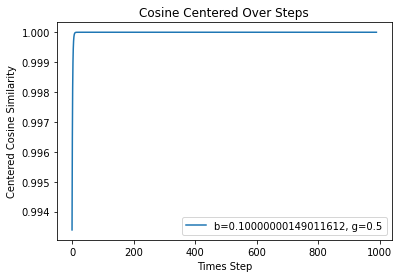

tau for b=0.10000000149011612 and g=0.5: 1.5975995969562158


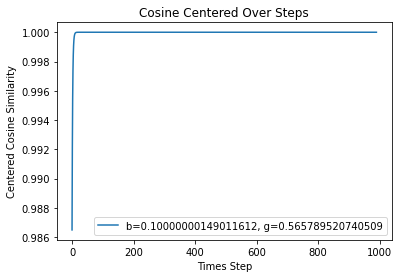

tau for b=0.10000000149011612 and g=0.5657894611358643: 1.8447003862954743


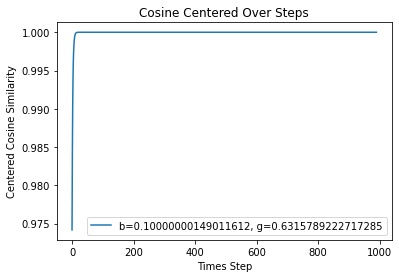

tau for b=0.10000000149011612 and g=0.6315789222717285: 2.1713516785245712


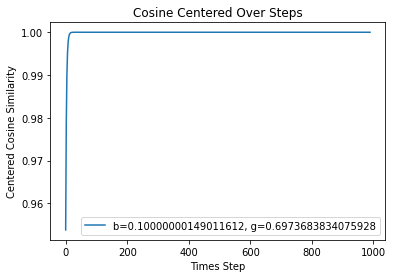

tau for b=0.10000000149011612 and g=0.6973683834075928: 2.6186976564730537


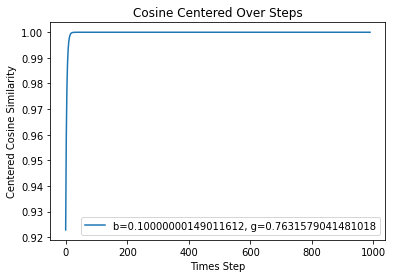

tau for b=0.10000000149011612 and g=0.763157844543457: 3.2514414526566915


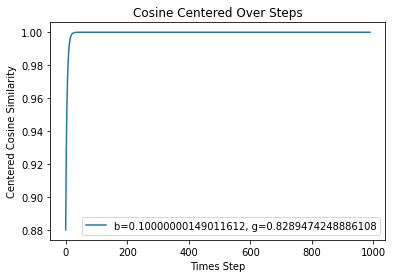

tau for b=0.10000000149011612 and g=0.8289473652839661: 4.173869947185048


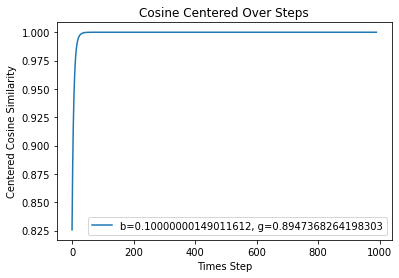

tau for b=0.10000000149011612 and g=0.8947368264198303: 5.5814143649072685


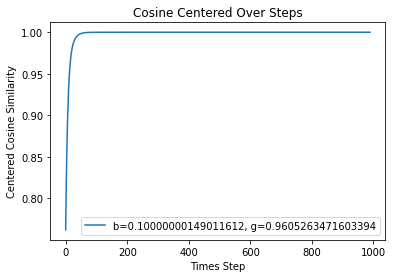

tau for b=0.10000000149011612 and g=0.9605262875556946: 7.994448634765246


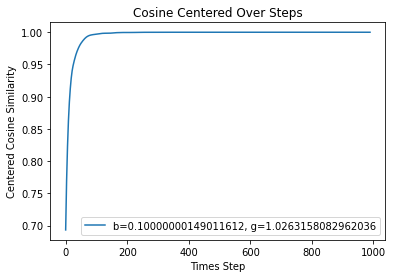

tau for b=0.10000000149011612 and g=1.0263158082962036: 13.899855831538952


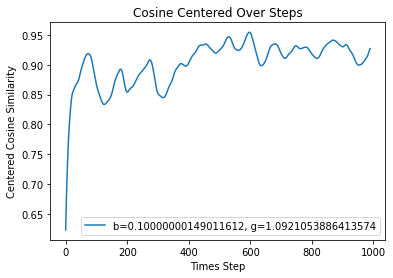

tau for b=0.10000000149011612 and g=1.0921052694320679: 15.099292241169964


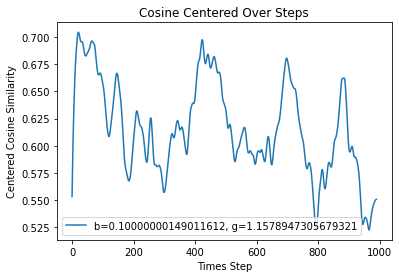

tau for b=0.10000000149011612 and g=1.1578947305679321: 1.5605450134917362


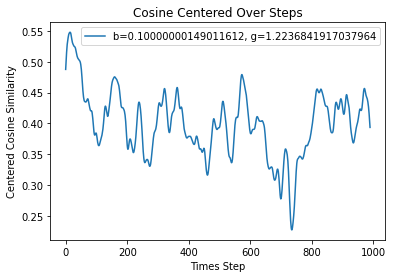

tau for b=0.10000000149011612 and g=1.2236841917037964: 67.8199482419041


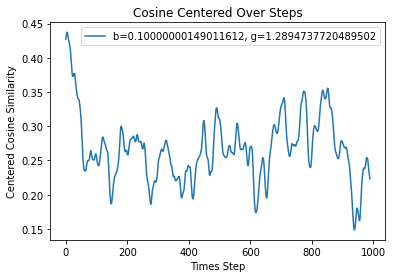

tau for b=0.10000000149011612 and g=1.2894736528396606: 28.50150569993255


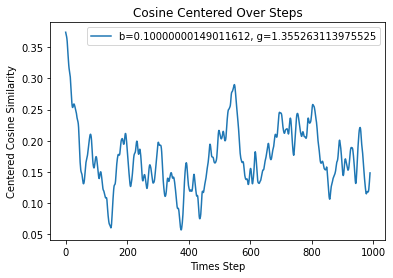

tau for b=0.10000000149011612 and g=1.355263113975525: 21.564164310852014


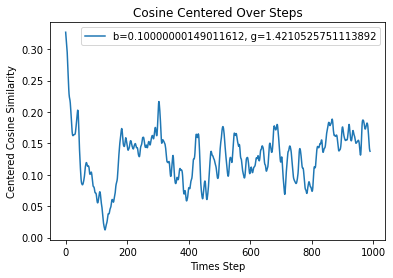

tau for b=0.10000000149011612 and g=1.4210525751113892: 15.357570228218542


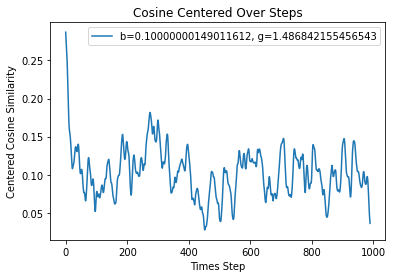

tau for b=0.10000000149011612 and g=1.4868420362472534: 11.31344038311891


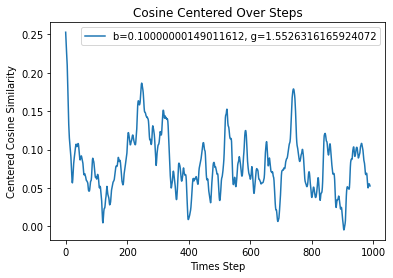

tau for b=0.10000000149011612 and g=1.5526316165924072: 7.893471335629151


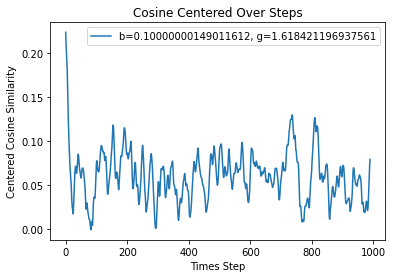

tau for b=0.10000000149011612 and g=1.6184210777282715: 6.4999301997364825


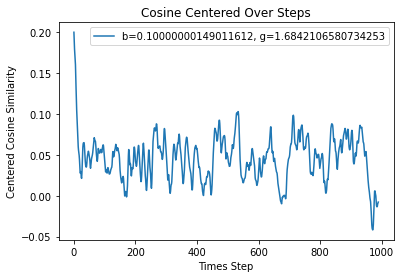

tau for b=0.10000000149011612 and g=1.6842105388641357: 7.200705567260821


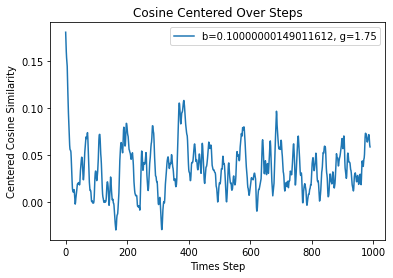

tau for b=0.10000000149011612 and g=1.75: 7.056134631163621


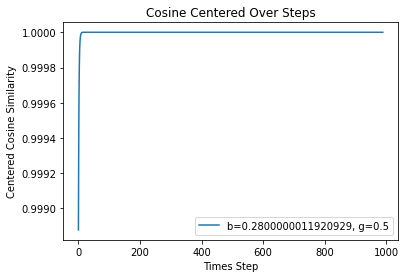

tau for b=0.2800000011920929 and g=0.5: 1.6589276867153306


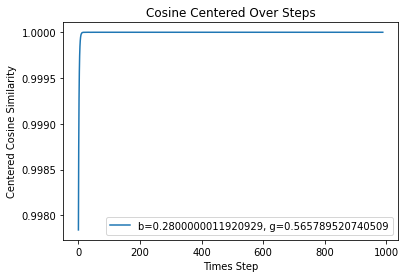

tau for b=0.2800000011920929 and g=0.5657894611358643: 1.8616365015965493


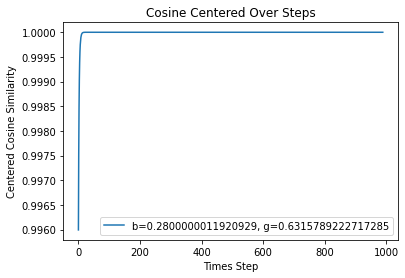

tau for b=0.2800000011920929 and g=0.6315789222717285: 2.118191898701877


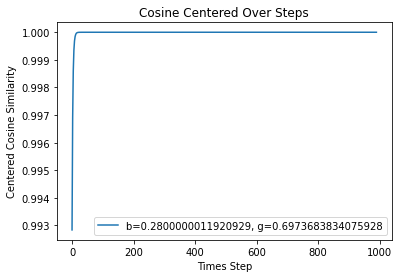

tau for b=0.2800000011920929 and g=0.6973683834075928: 2.4520435768203432


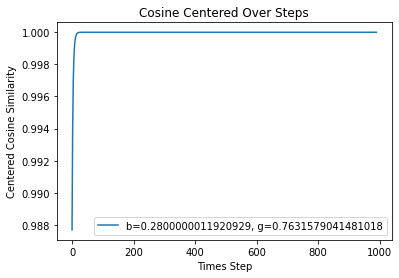

tau for b=0.2800000011920929 and g=0.763157844543457: 2.894985023354071


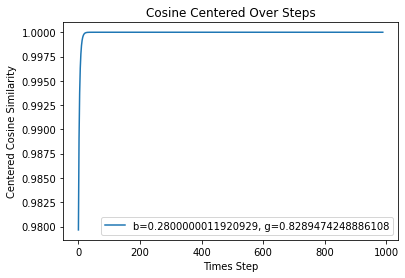

tau for b=0.2800000011920929 and g=0.8289473652839661: 3.5048618295732834


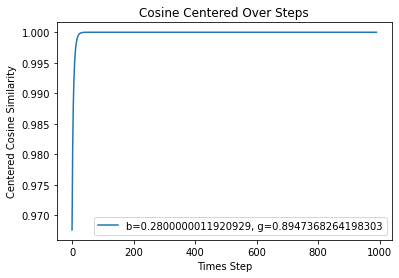

tau for b=0.2800000011920929 and g=0.8947368264198303: 4.3865894145210875


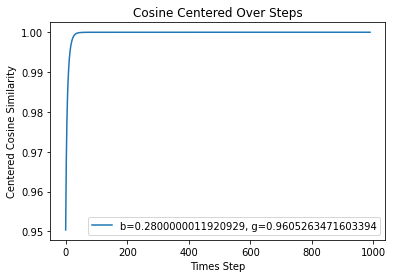

tau for b=0.2800000011920929 and g=0.9605262875556946: 5.782622085524555


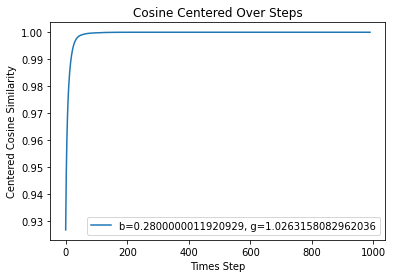

tau for b=0.2800000011920929 and g=1.0263158082962036: 8.46228921999294


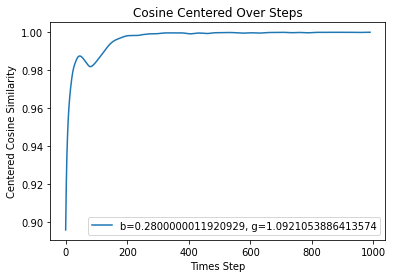

tau for b=0.2800000011920929 and g=1.0921052694320679: 44.900149420544224


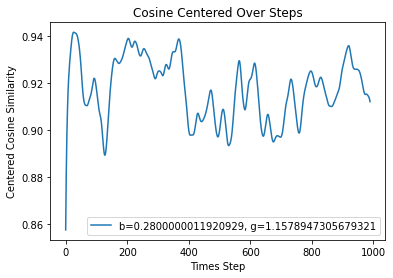

tau for b=0.2800000011920929 and g=1.1578947305679321: 2.7734266323502714


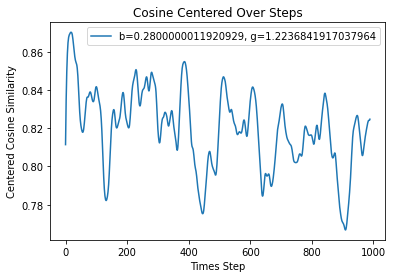

/opt/tmp/tmp/ipykernel_141139/3043143168.py:5: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-t / tau) + C


tau for b=0.2800000011920929 and g=1.2236841917037964: 0.025006283063825185


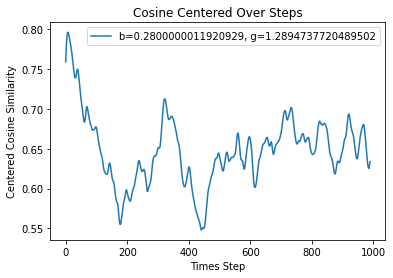

tau for b=0.2800000011920929 and g=1.2894736528396606: 42.88802856160602


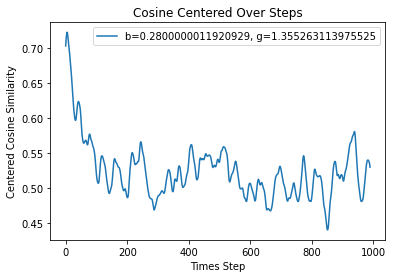

tau for b=0.2800000011920929 and g=1.355263113975525: 46.40168456457085


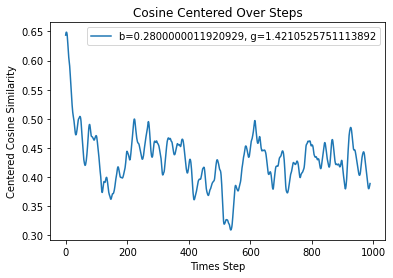

tau for b=0.2800000011920929 and g=1.4210525751113892: 29.51953173803339


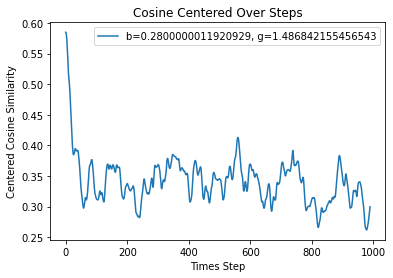

tau for b=0.2800000011920929 and g=1.4868420362472534: 17.263200400451424


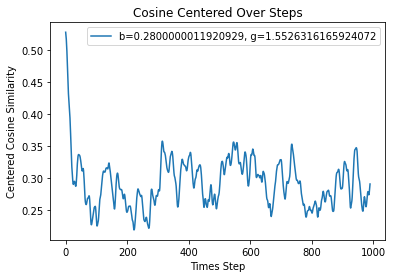

tau for b=0.2800000011920929 and g=1.5526316165924072: 12.217666154745466


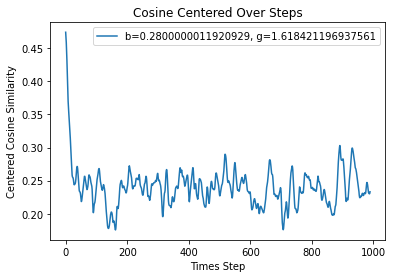

tau for b=0.2800000011920929 and g=1.6184210777282715: 11.350720168043068


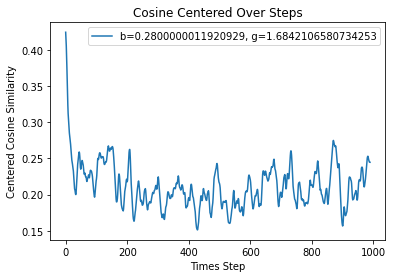

tau for b=0.2800000011920929 and g=1.6842105388641357: 12.726551835157576


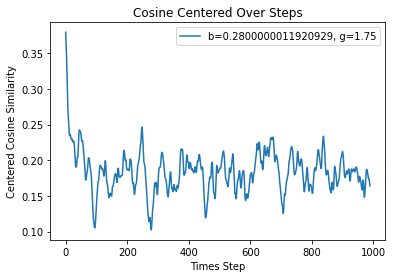

tau for b=0.2800000011920929 and g=1.75: 18.394224046979424


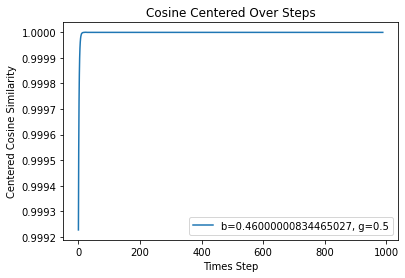

tau for b=0.46000000834465027 and g=0.5: 1.9479768996410043


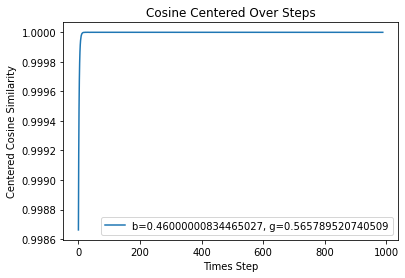

tau for b=0.46000000834465027 and g=0.5657894611358643: 2.127506506971879


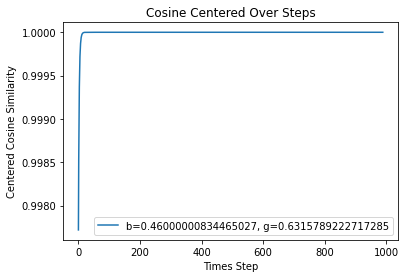

tau for b=0.46000000834465027 and g=0.6315789222717285: 2.3591113142569795


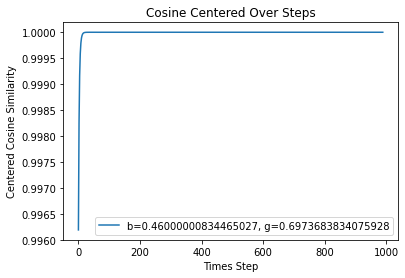

tau for b=0.46000000834465027 and g=0.6973683834075928: 2.6512530961212004


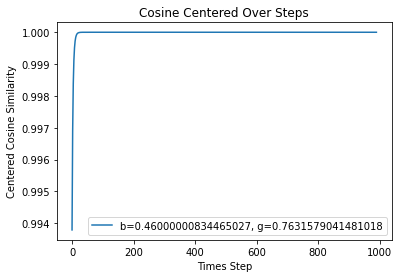

tau for b=0.46000000834465027 and g=0.763157844543457: 3.0243817156129675


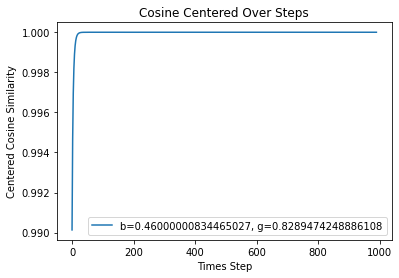

tau for b=0.46000000834465027 and g=0.8289473652839661: 3.5204632086877647


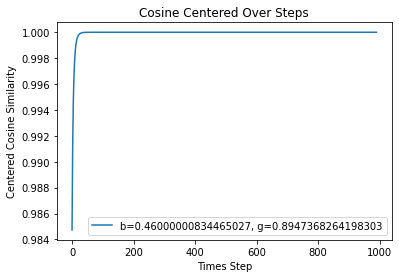

tau for b=0.46000000834465027 and g=0.8947368264198303: 4.217033360698781


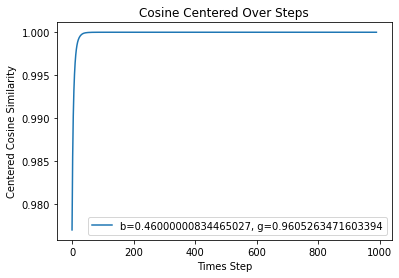

tau for b=0.46000000834465027 and g=0.9605262875556946: 5.310464588042519


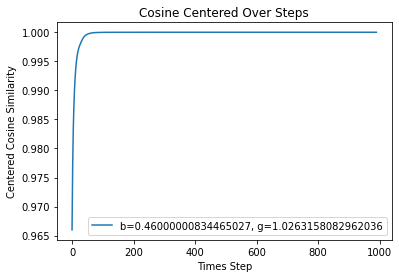

tau for b=0.46000000834465027 and g=1.0263158082962036: 7.459528721726132


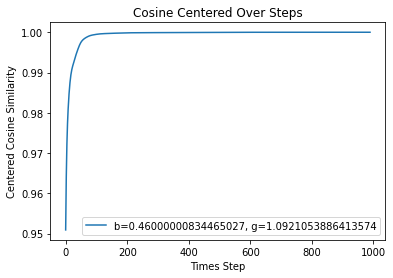

tau for b=0.46000000834465027 and g=1.0921052694320679: 13.515899595709476


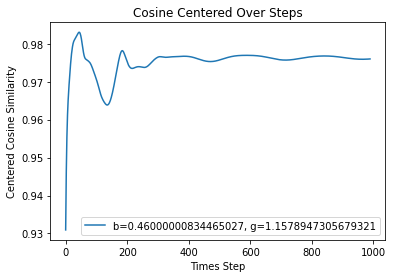

tau for b=0.46000000834465027 and g=1.1578947305679321: 4.956397162826579


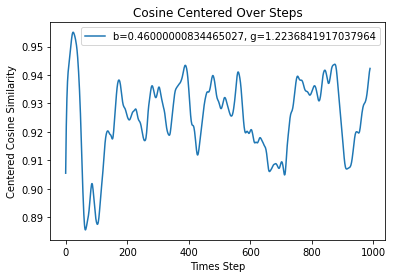

tau for b=0.46000000834465027 and g=1.2236841917037964: 0.9469244546797784


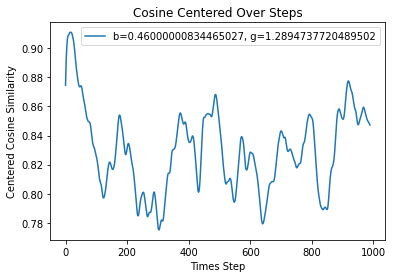

tau for b=0.46000000834465027 and g=1.2894736528396606: 44.91592671515779


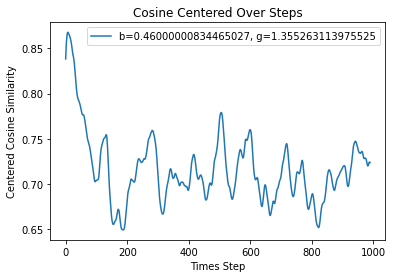

tau for b=0.46000000834465027 and g=1.355263113975525: 43.90071812102961


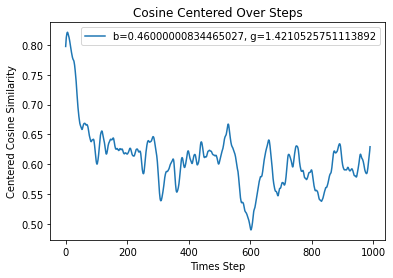

tau for b=0.46000000834465027 and g=1.4210525751113892: 65.39471286781415


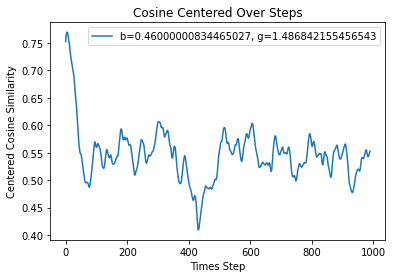

tau for b=0.46000000834465027 and g=1.4868420362472534: 23.92546480066558


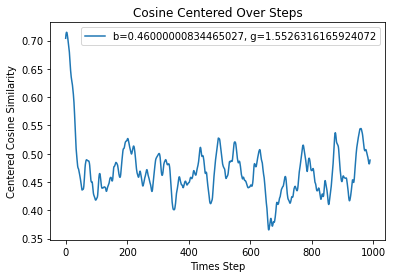

tau for b=0.46000000834465027 and g=1.5526316165924072: 20.832245283023923


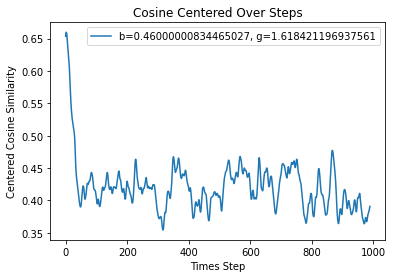

tau for b=0.46000000834465027 and g=1.6184210777282715: 18.18431297491428


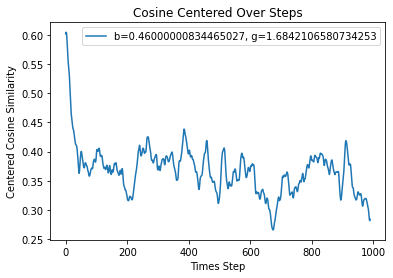

tau for b=0.46000000834465027 and g=1.6842105388641357: 20.533006089147126


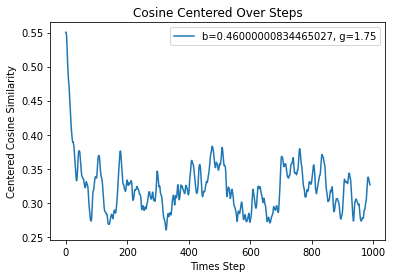

tau for b=0.46000000834465027 and g=1.75: 19.441873182049445


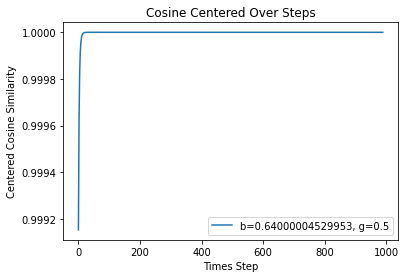

tau for b=0.64000004529953 and g=0.5: 2.5659752934621944


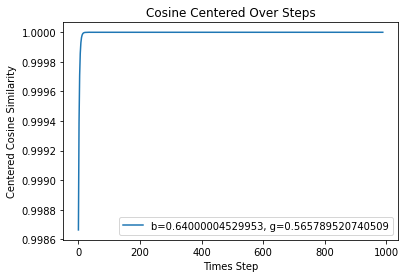

tau for b=0.64000004529953 and g=0.5657894611358643: 2.6339833477888654


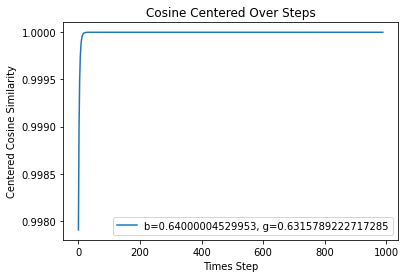

tau for b=0.64000004529953 and g=0.6315789222717285: 2.8756589290669567


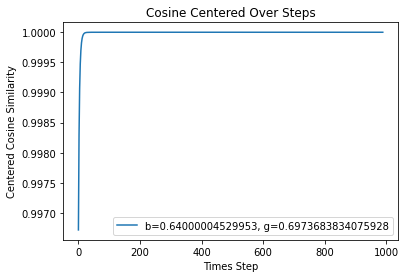

tau for b=0.64000004529953 and g=0.6973683834075928: 3.2481363226180773


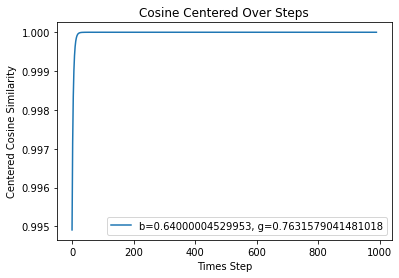

tau for b=0.64000004529953 and g=0.763157844543457: 3.6792329504547174


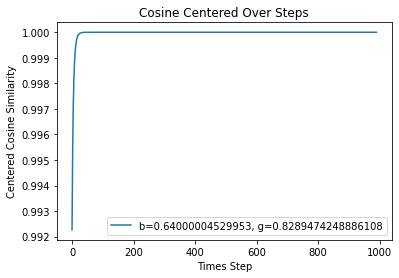

tau for b=0.64000004529953 and g=0.8289473652839661: 4.250967738861318


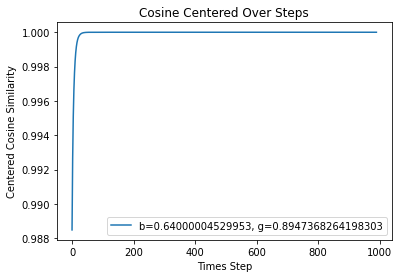

tau for b=0.64000004529953 and g=0.8947368264198303: 5.0880433754163


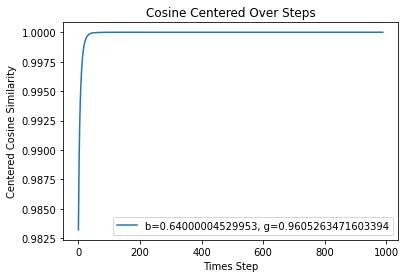

tau for b=0.64000004529953 and g=0.9605262875556946: 6.318232217525549


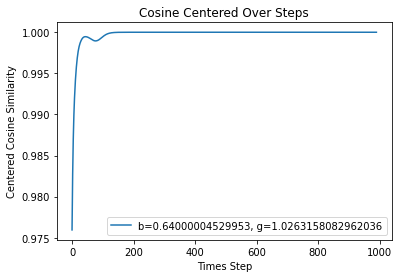

tau for b=0.64000004529953 and g=1.0263158082962036: 8.102933471305024


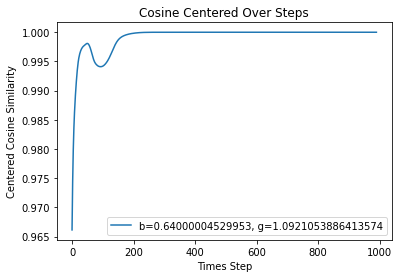

tau for b=0.64000004529953 and g=1.0921052694320679: 10.886158332095297


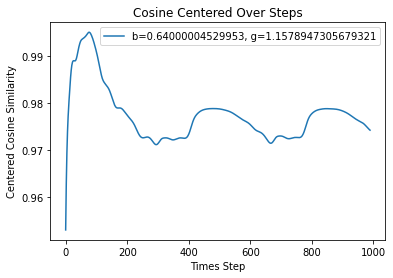

tau for b=0.64000004529953 and g=1.1578947305679321: 2.7904151339610648


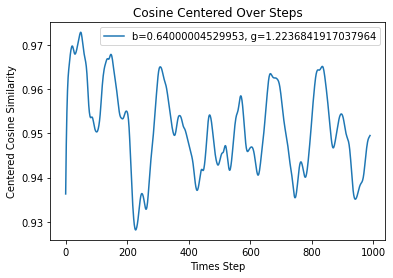

tau for b=0.64000004529953 and g=1.2236841917037964: 1.0664788180138713


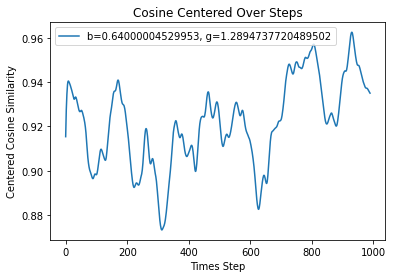

tau for b=0.64000004529953 and g=1.2894736528396606: 0.028275970218378077


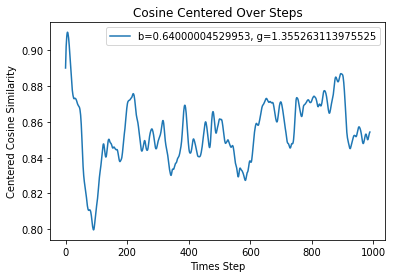

tau for b=0.64000004529953 and g=1.355263113975525: 17.247274084882505


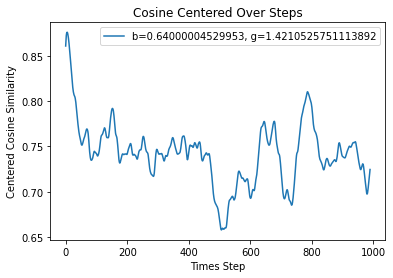

tau for b=0.64000004529953 and g=1.4210525751113892: 37.85920281097777


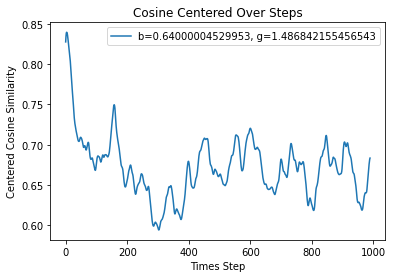

tau for b=0.64000004529953 and g=1.4868420362472534: 39.693988999259425


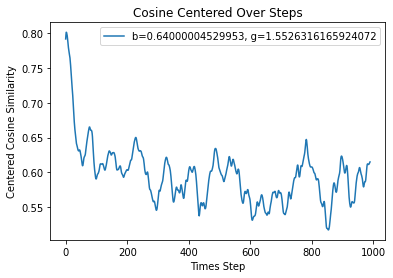

tau for b=0.64000004529953 and g=1.5526316165924072: 53.97137390148182


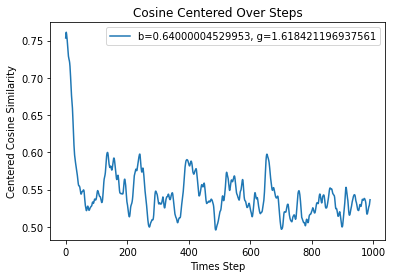

tau for b=0.64000004529953 and g=1.6184210777282715: 20.57985509104704


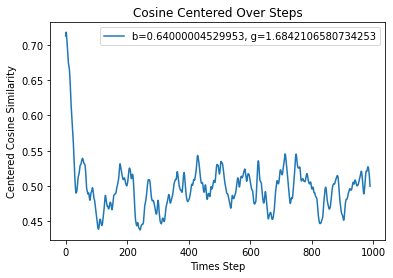

tau for b=0.64000004529953 and g=1.6842105388641357: 18.8337249183537


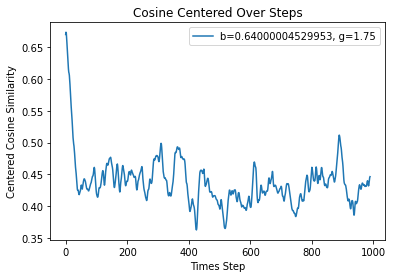

tau for b=0.64000004529953 and g=1.75: 16.787862525825762


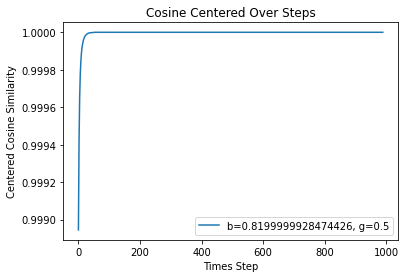

tau for b=0.8199999928474426 and g=0.5: 4.050017381115239


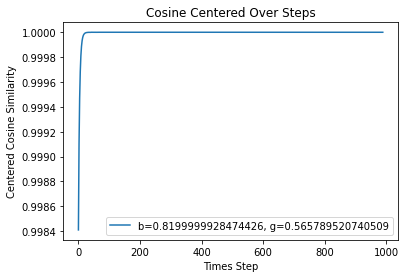

tau for b=0.8199999928474426 and g=0.5657894611358643: 3.710221276016381


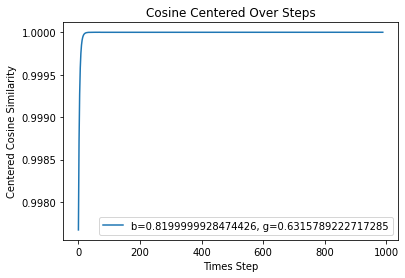

tau for b=0.8199999928474426 and g=0.6315789222717285: 3.525355501041136


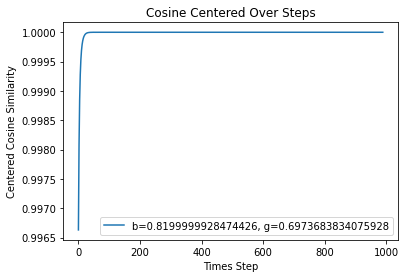

tau for b=0.8199999928474426 and g=0.6973683834075928: 3.9653368042262604


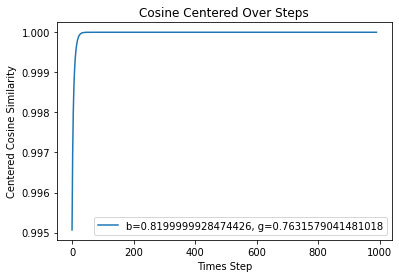

tau for b=0.8199999928474426 and g=0.763157844543457: 4.956206325841743


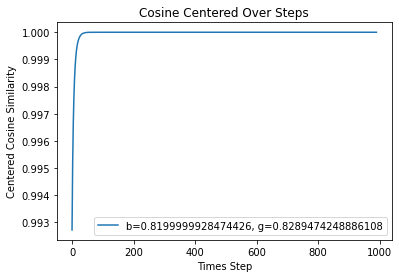

tau for b=0.8199999928474426 and g=0.8289473652839661: 5.7776635463366945


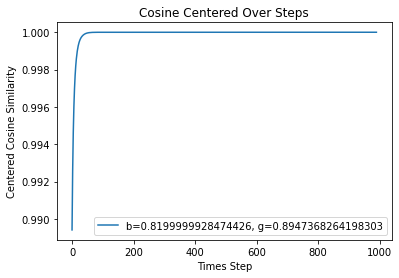

tau for b=0.8199999928474426 and g=0.8947368264198303: 6.836591141306162


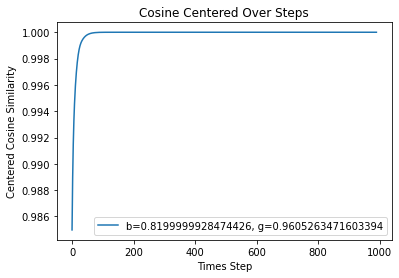

tau for b=0.8199999928474426 and g=0.9605262875556946: 8.995707180582587


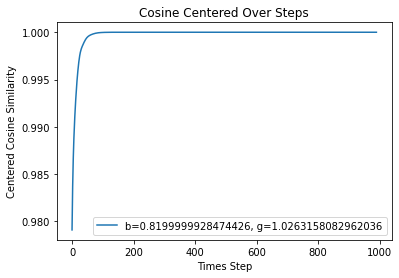

tau for b=0.8199999928474426 and g=1.0263158082962036: 12.002608874907446


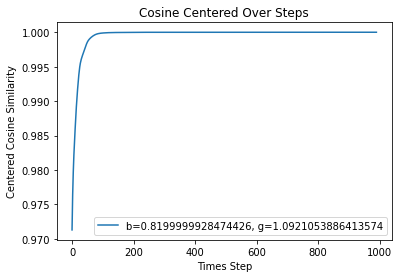

tau for b=0.8199999928474426 and g=1.0921052694320679: 15.5295837813852


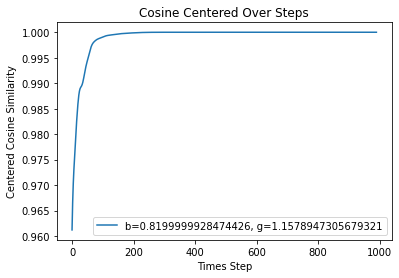

tau for b=0.8199999928474426 and g=1.1578947305679321: 24.727725803369434


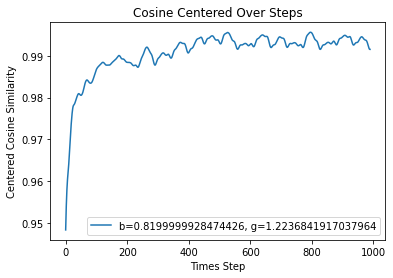

tau for b=0.8199999928474426 and g=1.2236841917037964: 68.92537148532861


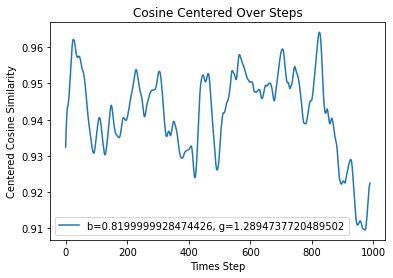

tau for b=0.8199999928474426 and g=1.2894736528396606: 1.580056830733469


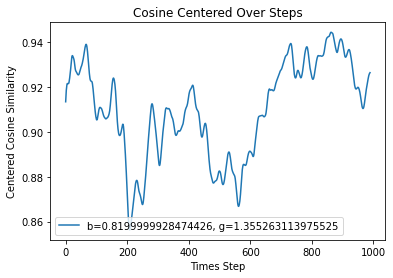

tau for b=0.8199999928474426 and g=1.355263113975525: 53.94906159528201


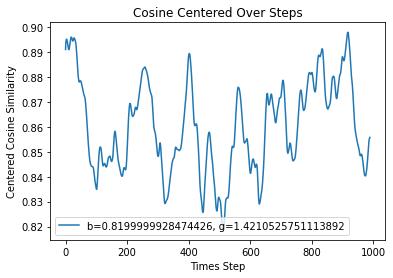

tau for b=0.8199999928474426 and g=1.4210525751113892: 31.607990071338953


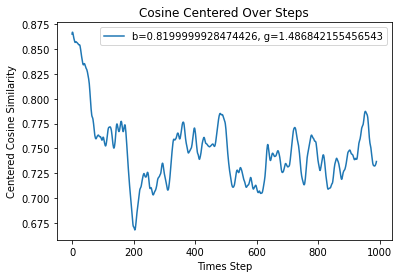

tau for b=0.8199999928474426 and g=1.4868420362472534: 56.27915646158033


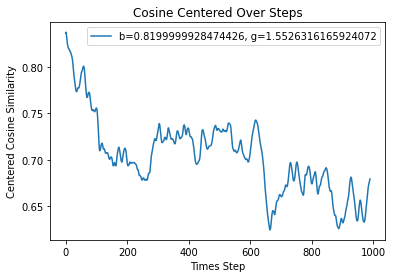

tau for b=0.8199999928474426 and g=1.5526316165924072: 1000.0


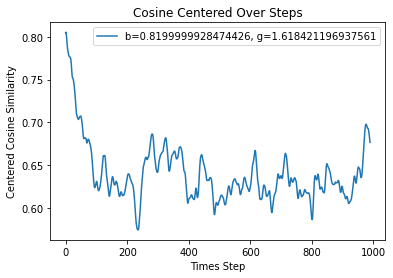

tau for b=0.8199999928474426 and g=1.6184210777282715: 42.082121728854126


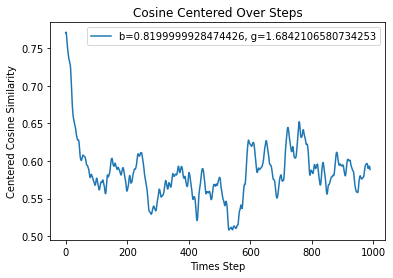

tau for b=0.8199999928474426 and g=1.6842105388641357: 25.949423138597115


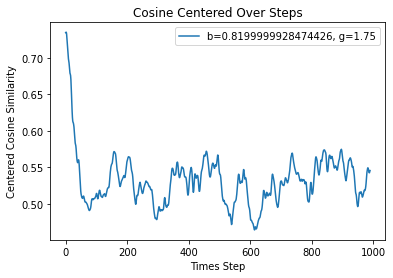

tau for b=0.8199999928474426 and g=1.75: 18.71589821977055


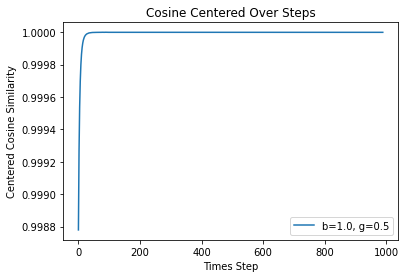

tau for b=1.0 and g=0.5: 4.419694003917202


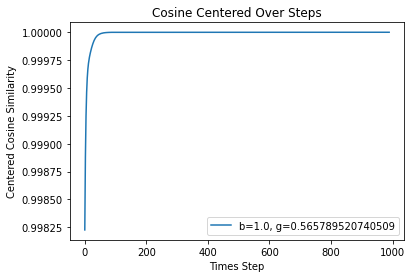

tau for b=1.0 and g=0.5657894611358643: 6.4611128514292995


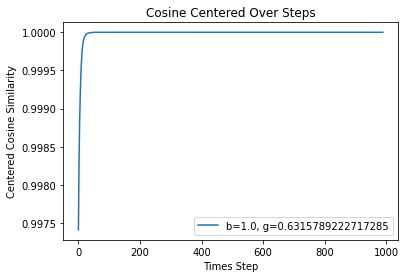

tau for b=1.0 and g=0.6315789222717285: 5.173940344663062


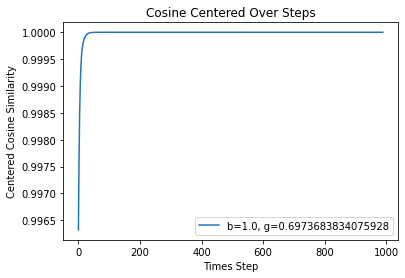

tau for b=1.0 and g=0.6973683834075928: 4.7050739408397515


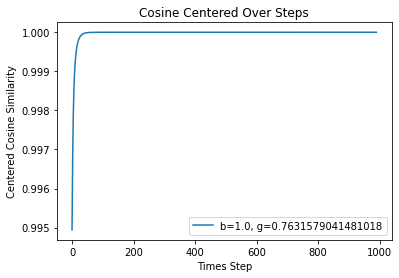

tau for b=1.0 and g=0.763157844543457: 5.34129737676959


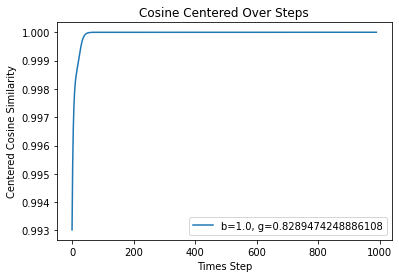

tau for b=1.0 and g=0.8289473652839661: 9.553076632694646


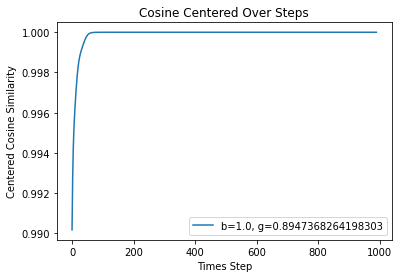

tau for b=1.0 and g=0.8947368264198303: 11.84930612186246


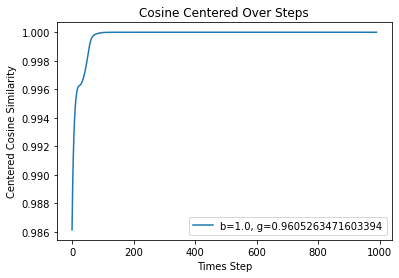

tau for b=1.0 and g=0.9605262875556946: 23.660036422295523


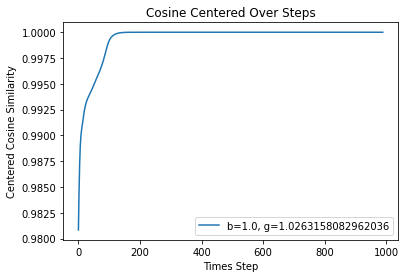

tau for b=1.0 and g=1.0263158082962036: 43.08063699562176


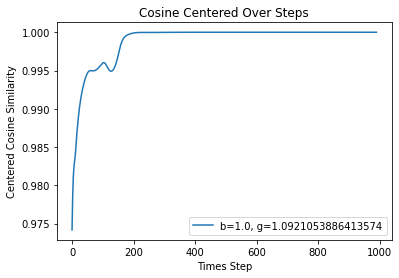

tau for b=1.0 and g=1.0921052694320679: 57.60761303832491


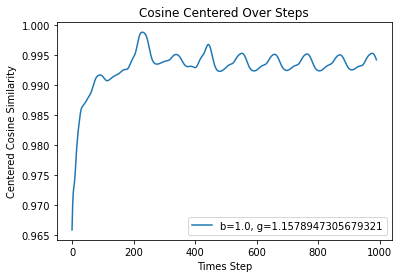

tau for b=1.0 and g=1.1578947305679321: 36.79131281204743


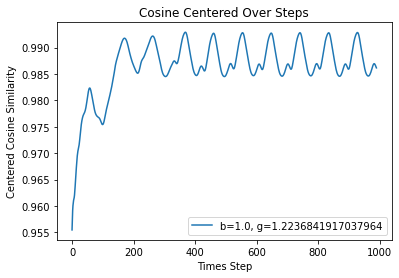

tau for b=1.0 and g=1.2236841917037964: 62.6054481200013


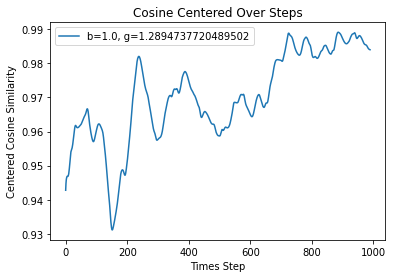

tau for b=1.0 and g=1.2894736528396606: 1000.0


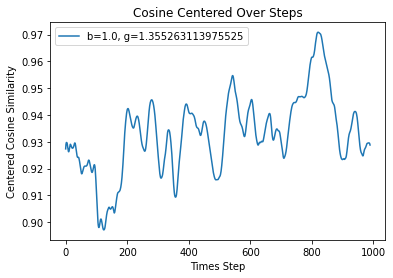

tau for b=1.0 and g=1.355263113975525: 576.957083373551


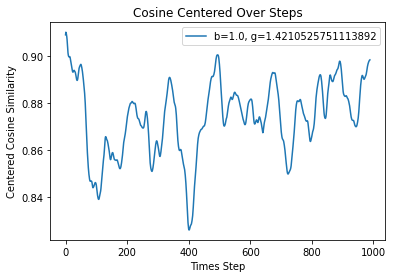

tau for b=1.0 and g=1.4210525751113892: 23.972568873912536


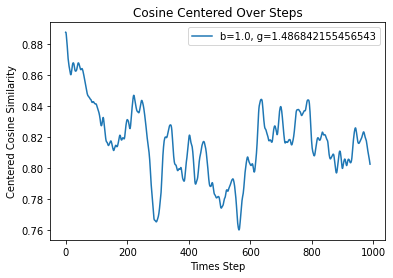

tau for b=1.0 and g=1.4868420362472534: 92.80360949333884


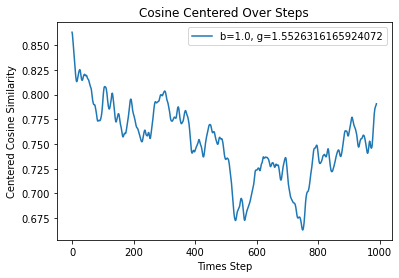

tau for b=1.0 and g=1.5526316165924072: 256.40688965825467


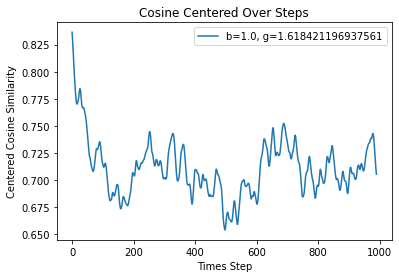

tau for b=1.0 and g=1.6184210777282715: 34.649142600421186


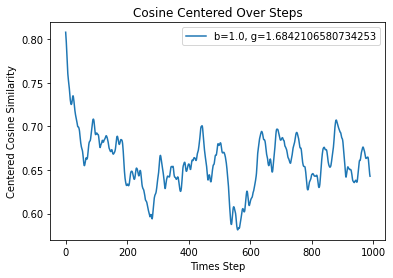

tau for b=1.0 and g=1.6842105388641357: 55.503554542359105


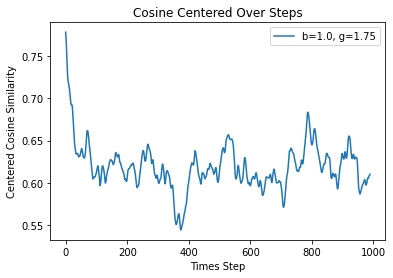

tau for b=1.0 and g=1.75: 23.761951249249435


In [78]:
for b_idx, b in enumerate(bias_values):
    for g_idx, vol in enumerate(g):
        tau[b_idx, g_idx] = compute_tau_c(b, vol, seeds, hidden_size, num_steps)
        print(f"tau for b={b} and g={g_factors[g_idx]}: {float(tau[b_idx, g_idx])}")

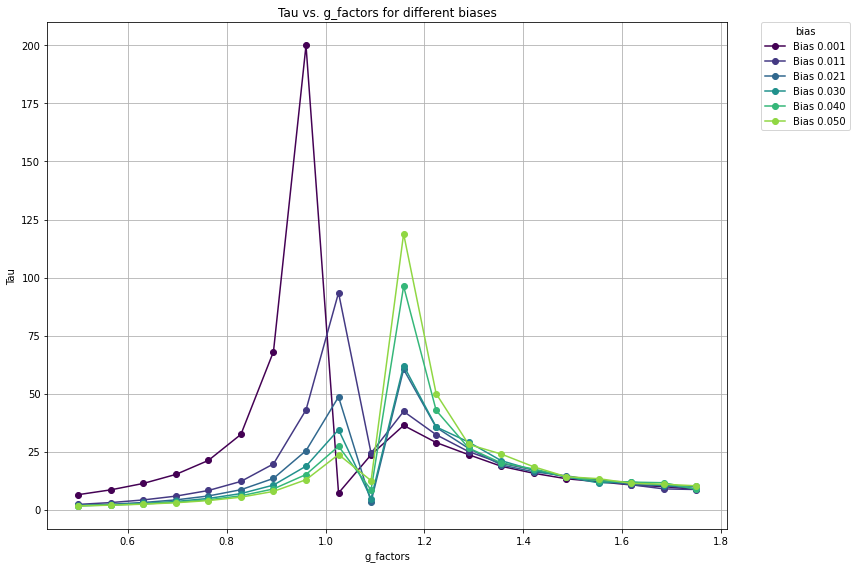

In [58]:
cmap = plt.get_cmap('viridis')  
colors = [cmap(i / len(bias_values) )for i in range(len(bias_values))]  

plt.figure(figsize=(12, 8))

for i in range(len(bias_values)):
    plt.plot(g_factors, tau[i, :], label=f'Bias {bias_values[i]:.3f}', color=colors[i], marker='o')


plt.title('Tau vs. g_factors for different biases')
plt.xlabel('g_factors')
plt.ylabel('Tau')
plt.legend(title='bias', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)

plt.tight_layout()
plt.savefig('Tau_vs_g_factors.png') 
plt.show()


In [55]:
jobs = [{'b': float(b), 'g_factor': float(g_factor)} for b in bias_values for g_factor in g]
results = parallelize(
    exec_func=compute_tau_c,
    jobs=jobs,
    single_arg = True,
    exec_kwargs=dict(seeds = seeds, hidden_size=hidden_size, num_steps=num_steps),
    mode="slurm",
    wait_for_graph_execution=False,
    root_dir=f"/mnt/live/user/tfioratti/parallelize_test",
)

Graph tfioratti__parallelize_test posted. Follow the execution using the [grid view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/manage/tfioratti__parallelize_test) or the [graph view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/display/tfioratti__parallelize_test)

In [56]:
import json
from pathlib import Path

results_dir = Path("/mnt/live/user/tfioratti/parallelize_test/execution_results")

data_dict = {}

for result_file in results_dir.glob("*.json"):  
    with open(result_file, 'r') as file:
        data = json.load(file)
    tau_value = data  
    file_key = result_file.stem
    data_dict[file_key] = tau_value

print(data_dict)

{'15': 13.325956999813204, '118': 10.947872761381225, '16': 12.001213829384705, '17': 10.647096670075529, '74': 17.018060065410207, '109': 12.501110711042712, '119': 10.275150537297023, '55': 14.574123947264075, '41': 2.3339640817159255, '54': 16.30276089067865, '100': 1.6330811238737322, '20': 2.258858021589397, '21': 3.0515905031451727, '113': 23.957207756795118, '19': 8.723753276758364, '52': 26.379483063271636, '36': 12.856984512654448, '51': 35.44826197194816, '53': 19.272734676218672, '35': 14.125347546683523, '50': 60.426904136783094, '0': 6.462463956632282, '48': 48.58748166497592, '46': 13.46596505153368, '37': 10.716032093570622, '101': 1.933496635070762, '44': 5.90063739213537, '18': 9.92170354497296, '38': 8.94780742590208, '42': 3.0877794251100945, '47': 25.404112615224268, '49': 3.39520044348132, '45': 8.589405402417212, '30': 42.326778417916955, '31': 32.2879848208146, '112': 28.10176443017245, '108': 23.74742872728626, '43': 4.209792134639177, '106': 7.863703809584533, 

In [57]:
full_range_keys = [str(i) for i in range(120)]

tau_values_list = [data_dict.get(key, np.nan) for key in full_range_keys]

tau = np.array(tau_values_list).reshape(6, 20)
